<a href="https://colab.research.google.com/github/variableVG/CV_project/blob/master/06_PyTorch_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [235]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Data and images


In [270]:
path_to_pictures = '/content/pic/'
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces_small.csv'

In [240]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os

In [241]:
# Use Google Collabs GPU
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()

def to_device(data, device=device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)



In [271]:
#Get .tar file with pytorch files from google drive
! pip install gdown
! mkdir -p /content/pic/
! gdown -O /content/pytorch_files.tar "1Eqds2UxvtLkFefRp00wNVdyX4jdiYlav"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1Eqds2UxvtLkFefRp00wNVdyX4jdiYlav
To: /content/pytorch_files.tar
100% 496M/496M [00:03<00:00, 128MB/s] 


In [272]:
import tarfile
try: 
  tar = tarfile.open('/content/pytorch_files.tar')
  tar.extractall(path='/content/pic')
  tar.close()
except:
  print("Pictures could not be extracted")

In [276]:
! mv /content/pic/content/drive/MyDrive/Colab\ Notebooks/CVNLP/normalized_tensor_images/* /content/pic/
! rmdir /content/pic/content

mv: cannot stat '/content/pic/content/drive/MyDrive/ColabNotebooks/CVNLP/normalized_tensor_images/*': No such file or directory
rmdir: failed to remove '/content/pic/content': Directory not empty


In [281]:
df = pd.read_csv(path_to_dataset)

In [282]:
df.head()

,filename,age,gender,ethnicity
0,36_1_1_20170116223054510.jpg,36,1,1
1,36_1_1_20170117165628076.jpg,36,1,1
2,37_0_0_20170117140720825.jpg,37,0,0
3,37_0_1_20170116193744974.jpg,37,0,1
4,37_0_1_20170117140332549.jpg,37,0,1


In [283]:
df.shape

(2501, 4)

We are going to separate 16 pictures to use at the end of this notebook to make predictions. These 16 photos will not be used by the model to train or test (validate). This means that our model has never seen these photographs until the moment of prediction. So we will see, how well (or bad) our network works.

In [284]:
import random
# Generate a list of 16 random indexes
random_indexes = [random.randint(0,len(df)) for i in range(0,16)]

# Create a new DataFrame that stores the information for those 16 pictures. 
pictures_for_prediction = pd.DataFrame()

for idx in random_indexes: 
  # Add picture to new dataset
  pictures_for_prediction = pictures_for_prediction.append(df.iloc[idx], ignore_index = True)
  # Delete picture from df
  df.drop(idx, inplace=True)

In [285]:
print(df.shape)
print(pictures_for_prediction.shape)

(2485, 4)
(16, 4)


# Create Dataset and Load Pictures with Data Loader

Because my RAM was constantly crashing and taking a long time to upload photos, I created a class that uses torch.load() and loads directly the images as torch files which seems more efficient

In [320]:
# SOurce: https://pytorch.org/docs/stable/data.html
# We want a class that implements the image dataset to be able to request pictures
# by need and not load all pictures at once (RAM crashes)

class TensorDataset(torch.utils.data.Dataset): 
  def __init__(self, df):
    super().__init__()
    self.df = df

  def __len__(self): 
    return len(self.df)

  def __getitem__(self, idx): # by __getitem__ return a tupel of (picture, label)
    basename, extension = os.path.splitext(self.df['filename'].iloc[idx])
    path = path_to_pictures + basename + '.pth'
    label = self.df['age'].iloc[idx]
  
    torch_picture = torch.load(path)
    #torch_picture = self.doAugmentation(torch_picture)
    return (torch_picture, label)
   
    
  
  def doAugmentation(self, torch_picture): 
    random = 0
    picture = torch.Compose(torch.RandomCrop(), torch.RandomHorizontalFlip())


In [321]:
# Create tensor dataset 
tensor_dataset = TensorDataset(df)
print(len(tensor_dataset))

2485


In [322]:
img, label = tensor_dataset.__getitem__(3)
print(img.shape, label)
# Element at index 3 is a pytorch image with age 37. 

torch.Size([3, 128, 128]) 37


In [323]:
# split dataset with PyTorch
test_size = int(len(tensor_dataset) * 0.2)
train_size = len(tensor_dataset) - test_size
print(f"Dataset has length {len(tensor_dataset)}, train set has length {train_size} and test set has length {test_size}.")
print(f"Sum of test and train sets is {train_size + test_size}.")

Dataset has length 2485, train set has length 1988 and test set has length 497.
Sum of test and train sets is 2485.


In [324]:
from torch.utils.data import random_split
# Random numbers will be generated always on the same way, so we can compare models. 
random_seed = 42
torch.manual_seed(random_seed)

# Split dataset
train_ds, test_ds = random_split(tensor_dataset, [train_size, test_size])
print(len(train_ds))
print(len(test_ds))

1988
497


In [325]:
# Load Data with DataLoader
batch_size=8

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size)

# Create Model

In [326]:
# Define initial number of kernels. 
num_pixels_x = 128
num_pixels_y = 128
num_kernels = 16

In [327]:
# Source: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

from torch import nn

class Model(nn.Module): 
  def __init__(self): 
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, num_kernels, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 
        #MaxPool reduce the size of the image by half (if it was 32x32, becomes 16x16)

        nn.Conv2d(num_kernels*2, num_kernels*3, kernel_size=3, padding=1, stride=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels*3, num_kernels*3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 

        nn.Conv2d(num_kernels*3, num_kernels*4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels*4, num_kernels*4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # MaxPool2d reduces the image of a picture by half
        nn.MaxPool2d(2,2), # Output:8x4096

        # Flatten() reduces the 3 dimensions in one dimension. 
        nn.Flatten(), 
        nn.Linear(num_pixels_x*num_pixels_y*num_kernels // 16, num_kernels*4), 
        nn.ReLU(),
        nn.Linear(num_kernels*4, num_kernels*2),
        nn.ReLU(),
        nn.Linear(num_kernels*2, 1), 
        #nn.ReLU(), # To make sure there is at the end a number > 0
    )
  def forward(self, x):
    return self.network(x)

# Train the model

In [328]:
def fit(model, train_loader, num_epochs, optimizer, loss_function):
  #log = {}
  # Tell the model we are in training mode. 
  # model.train()

  for epoch in range(num_epochs): # for each number of epochs. 
    model.train()
    sumloss = []
    for x, y in train_loader: # for each batch in the train loader: 
      x, y = to_device([x, y])
      prediction = model(x) # The prediction is 3x1 but we need a tensor of 3.
      y = y[:, None]
      #prediction = prediction.squeeze()
      loss = loss_function(prediction, y)
      sumloss.append(loss.detach().item())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #log[epoch] = sum(losses) / len(losses)
    print(f"Epoch [{epoch + 1 }/{num_epochs}] loss: {np.mean(sumloss):.3f}.")


In [329]:
# Initialize the model
model = to_device(Model())

number_param = 0
for param in model.parameters():
  number_param = number_param + np.prod(param.shape)

print(number_param)

1155137


In [330]:
# Create Optimizer
optimizer = torch.optim.Adam(model.parameters())
# Other optimizer could be the stochastic gradient descent
# torch.optim.SGD(model.parameters(), lr=1e-5)

# define loss function
loss_function = nn.L1Loss()

# Define num of epochs: 
num_epochs = 50

# Train the model using the function above: 
fit(model, train_loader, num_epochs, optimizer, loss_function)

Epoch [1/50] loss: 19.361.
Epoch [2/50] loss: 17.433.
Epoch [3/50] loss: 17.425.
Epoch [4/50] loss: 16.890.
Epoch [5/50] loss: 16.497.
Epoch [6/50] loss: 16.631.
Epoch [7/50] loss: 16.536.
Epoch [8/50] loss: 16.578.
Epoch [9/50] loss: 16.630.
Epoch [10/50] loss: 16.343.
Epoch [11/50] loss: 16.132.
Epoch [12/50] loss: 15.806.
Epoch [13/50] loss: 15.969.
Epoch [14/50] loss: 15.398.
Epoch [15/50] loss: 14.948.
Epoch [16/50] loss: 15.025.
Epoch [17/50] loss: 14.696.
Epoch [18/50] loss: 14.350.
Epoch [19/50] loss: 14.176.
Epoch [20/50] loss: 13.886.
Epoch [21/50] loss: 13.563.
Epoch [22/50] loss: 12.735.
Epoch [23/50] loss: 12.355.
Epoch [24/50] loss: 11.852.
Epoch [25/50] loss: 11.538.
Epoch [26/50] loss: 10.947.
Epoch [27/50] loss: 10.386.
Epoch [28/50] loss: 10.029.
Epoch [29/50] loss: 9.136.
Epoch [30/50] loss: 8.784.
Epoch [31/50] loss: 8.271.
Epoch [32/50] loss: 7.719.
Epoch [33/50] loss: 7.234.
Epoch [34/50] loss: 6.721.
Epoch [35/50] loss: 6.275.
Epoch [36/50] loss: 6.004.
Epoch [37

In [331]:
def evaluate(loader, name="Training"):
  # Get predictions
  absolute_error, total = 0, 0 

  # This tells PyTorch that the model is in evalution mode. This is to avoid that the model keeps saving weights and so on, also for performance reasons. 
  model.eval() 
  for idx, (x, y) in enumerate(loader):
    x, y = to_device((x,y))
    prediction = model(x).squeeze()
    #max_prob, prediction = torch.max(output, 1)
    total += y.size(0)
    absolute_error += ((prediction - y).abs()).sum().item()

  mean_absolute_error = absolute_error/ total 
  print(f"{name} => Mean Absolute error is {mean_absolute_error:.2f} years")

evaluate(train_loader)
evaluate(test_loader, "Testing")

Training => Mean Absolute error is 3.31 years
Testing => Mean Absolute error is 16.84 years


# Predict pictures

In [332]:
def predict(picture_filename_list, model):
  predictions = []
  # Get pictures
  for picture in picture_filename_list:
    basename, extension = os.path.splitext(picture)
    path = path_to_pictures + basename + '.pth'
    pic = torch.load(path)
    # We need to add a batch-dimension of 1 to be able to use the model, since our model works only in batches. 
    # For that we used the unsqueeze() function
    # https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
    pic = to_device(torch.load(path).unsqueeze(0))
    prediction = model(pic)
    # get the item from tensor 
    predictions.append(prediction.item())
  return predictions


In [333]:
# Get the picture we have reserved at the beginning of the blog
predictions = predict(pictures_for_prediction['filename'], model)

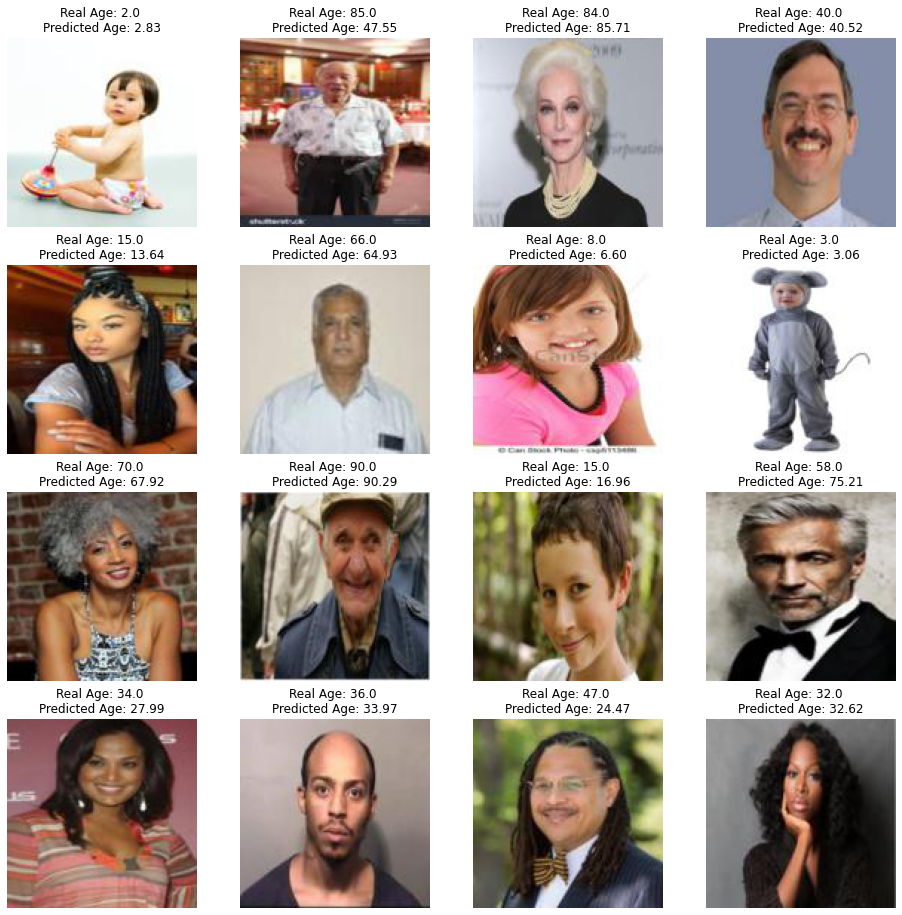

In [336]:
# plot real data and predictions + picture
from PIL import Image
path_to_real_pictures = '/content/drive/MyDrive/Colab Notebooks/CVNLP/small_pic/'
plt.figure(figsize=(16,16))

for i, picture in enumerate(pictures_for_prediction['filename']):
    plt.subplot(4, 4, i + 1) # index starts from 1, not 0
    # get picture
    path = path_to_real_pictures + picture
    try: 
      img = Image.open(path)
      plt.imshow(img)      
    except: 
      print(f"picture in {path} not found")
    plt.title(f"Real Age: {pictures_for_prediction['age'][i]} \nPredicted Age: {predictions[i]:.2f}")
    plt.axis('off')

In [335]:
#https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

SyntaxError: ignored